In [3]:
"""
Created on Apr 5th 2024
@author: Tony Huang
This file aims to replicate the different SML in FOMC announcement and non-announcement day from Bodilsen et al.(2021, JBF), namely 
"""
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as stm

folder = 'D:/Dropbox/Projects/Asset Pricing and Speeches by the Fed/'

In [5]:
def fomc_calendar(dir):
    """
    Function: construct the list of fomc meetings' date
    Input: Address of the file
    Output: A (list) that contains the date of fomc meeting since 2000
    """
    month_map = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_map = {month_map[i]: ('0' + str(i+1))[-2:] for i in range(len(month_map))}

    fomc_list = pd.read_excel(dir)
    fomc_list['not_meeting'] = fomc_list['date'].apply(lambda x: 0 if x.find('Cancelled') == -1 & x.find('Notation Vote') == -1 else 1)
    fomc_list = fomc_list[fomc_list['not_meeting'] == 0]
    fomc_list['date'] = fomc_list['date'].apply(lambda x: x.split(' (')[0])
    fomc_list['date'] = fomc_list['date'].apply(lambda x: x.split(' :')[0])
    fomc_list['conf_type'] = fomc_list['date'].apply(lambda x: x.split(', ')[0])
    fomc_list = fomc_list[fomc_list['conf_type'] == 'Meeting']
    fomc_list['date'] = fomc_list['date'].apply(lambda x: x.split(', ')[2] + ' ' + x.split(', ')[1])
    fomc_list['date'] = fomc_list['date'].apply(lambda x: x.split('-')[0].split(' ') + x.split('-')[1].split(' ') if x.find('-') != -1 else x)
    fomc_list['date'] = fomc_list['date'].apply(lambda x: (x[0] + ' ' + x[1] + ' ' + x[-1] if x[-2].isdigit() == 1 else (x[0] + ' ' + x[-2] + ' ' + x[-1])) if type(x) == list else x)
    fomc_list['date'] = fomc_list['date'].apply(lambda x: datetime.strptime(x.split(' ')[0] + month_map[x.split(' ')[1]] + ('0' + x.split(' ')[2])[-2:], '%Y%m%d'))
    fomc_list.sort_values(by='date', inplace=True)
    fomc_list = [fomc_list.iloc[i, 0] for i in range(fomc_list.shape[0])]

    fomc_list = list(map(lambda x: datetime.strftime(x, '%Y-%m-%d'), fomc_list))
    return fomc_list

def pc_calendar(dir):
    """
    Function: construct the list of pc day
    Input: Address of the file
    Output: A (list) that contains the date of fomc pc since 2000
    """
    pc_list = []
    for name in os.listdir(dir):
        pc_list.append(datetime.strptime(str(re.search('\d+', name).group()), '%Y%m%d'))

    pc_list = list(map(lambda x: datetime.strftime(x, '%Y-%m-%d'), pc_list))
    return pc_list

def speech_calendar(dir):
    transcripts = pd.read_excel(dir)
    
    # only keep speeches of the chairman
    transcripts['speaker'] = transcripts['file_name'].apply(lambda x: re.findall('[a-z]{2,}', x)[0])
    transcripts = transcripts[((transcripts['speaker'] == 'bernanke') & (transcripts['date'] < '2014-02-03')) | ((transcripts['speaker'] == 'powell') & (transcripts['date'] >= '2018-02-03')) | ((transcripts['speaker'] == 'yellen') & (transcripts['date'] >= '2014-02-03') & (transcripts['date'] < '2018-02-03'))]
    
    # keep speeches that are delivered during trading time
    transcripts = transcripts.dropna(subset=['minute'])
    transcripts['minute'] = transcripts['minute'].apply(lambda x: '10:00 a.m' if x == '10 a.m' else ('11:00 a.m' if x == '11 a.m' else x))
    transcripts['minute'] = transcripts['minute'].apply(lambda x: x.replace('.', '').upper())
    transcripts['minute'] = transcripts['minute'].apply(lambda x: datetime.strptime(x, '%I:%M %p'))
    transcripts = transcripts[transcripts['minute'] < datetime(year= 1900, month=1, day=1, hour=16, minute=0)]

    speech_list = [transcripts.loc[i, 'date'] for i in transcripts.index]
    # speech_list = transcripts
    return speech_list

fomc_list = fomc_calendar(folder + '_03_raw_data/fomc calendar.xlsx')
pc_list = pc_calendar(folder + '_03_raw_data/speeches/fomc_press_conferences')
speech_list = speech_calendar(folder + '_04_processed_date/complete_transcripts.xlsx')

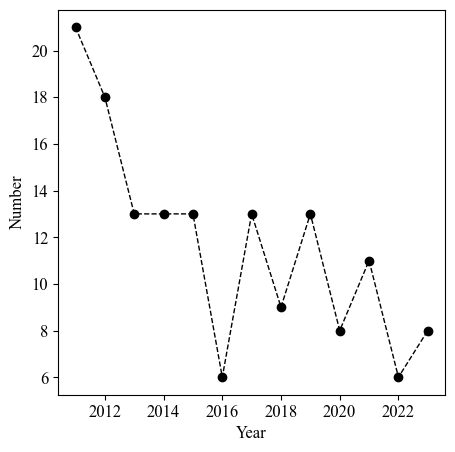

In [54]:
# speech_list['year'] = speech_list['date'].apply(lambda x: int(x.split('-')[0]))
# speech_list = speech_list[speech_list['year'] <= 2023]

# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 12
# f, ax = plt.subplots(figsize = (5, 5))
# speech_list = speech_list.groupby('year')['file_name'].nunique()
# ax.plot(speech_list.index, speech_list, marker = 'o', linewidth = 1, color = 'black', linestyle = '--')
# ax.set(xlabel = 'Year', ylabel = 'Number')
# plt.savefig(folder + '_05_output/figures/Number of Speeches.png')

In [96]:
data = pd.read_pickle(folder + '_03_raw_data/stock price/pickle files/price_2010_2023.pickle')
# data = data[(data['date'] >= '2010-04-01') & (data['date'] <= '2018-06-30')]
data.columns = map(lambda x: x.lower(), list(data.columns))
data = data[(data['prc'] > 5) & (data['shrcd'].isin([10, 11]))]
data = data.reset_index(drop=True)

risk_free = pd.read_csv(folder + '_03_raw_data/market yield on one-month treasury bill/DGS1MO.csv')
risk_free = risk_free.rename(columns={'DATE': 'date', 'DGS1MO': 'risk_free'})
data = data.merge(right=risk_free, on=['date'], how='left')

data = data[~data['ret'].isin(['B', 'C'])]
data['risk_free'] = np.where(data['risk_free'] == '.', np.nan, data['risk_free'])
data['risk_free'] = data['risk_free'].fillna(method='bfill')
data['ret'] = data['ret'].astype(float)
data['risk_free'] = data['risk_free'].astype(float)
# data['vwretd'] = data['vwretd'].astype(float)
data['stk_exr'] = data['ret']*100 - data['risk_free']/250
data['mkt_exr'] = data['vwretd']*100 - data['risk_free']/250
data['month'] = data['date'].apply(lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1]) )
data = data.merge(right=data['permno'].value_counts().reset_index(), on='permno', how='left')
data = data[data['count'] > 250]

In [98]:
# data = data[(data['date'] >= '2010-04-01') & (data['date'] <= '2011-06-30')]
data = data.reset_index(drop=True)
max_index = 10188087
def beta_calculator(df):
    global max_index
    print('\r{0}'.format(df.index[-1]/max_index * 100), end='')
    # df = df.reset_index(drop=True)
    beta = [np.nan]
    for i in range(1, df.shape[0]):
        if df['month'].iloc[i] == df['month'].iloc[i-1]: # if it is not the first day of a month
            beta.append(np.nan)
            continue
        else:
            month = df['month'].iloc[i]
            if df[(df['month'] <= month - 1) & (df['month'] >= month - 12)].shape[0] < 100:
                beta.append(np.nan)
                continue
            else:
                y = np.array((df[(df['month'] <= month - 1) & (df['month'] >= month - 12)]['stk_exr'])).reshape(-1, 1)
                x = np.array(stm.add_constant(df[(df['month'] <= month - 1) & (df['month'] >= month - 12)]['mkt_exr'])).reshape(-1, 2)
                if len(x) == 0:
                    beta.append(np.nan)
                else:
                    beta.append(np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)[1, 0])
    return pd.DataFrame(beta)
data['beta'] = data[['permno', 'date', 'month', 'stk_exr', 'mkt_exr']].groupby('permno').apply(lambda x: beta_calculator(x)).reset_index(drop=True)

100.066375051567756

In [6]:
data = pd.read_pickle(folder + '_04_processed_date/beta.pickle')
last_day = data[~data['beta'].isna()].reset_index(drop=True)

In [153]:
def gen_decile(df):
    bins = list(np.percentile(df, np.array(np.arange(10, 100, 10))))
    bins = [df.min()] + bins + [df.max()]

    return pd.cut(df, bins, labels = range(0, 10, 1))
    
last_day['port_num'] = last_day.groupby('month')['beta'].apply(lambda x: gen_decile(x)).droplevel(0)

In [ ]:
data = data.merge(right=last_day[['permno', 'date', 'port_num']], on=['permno', 'date'], how='left')
data[['beta', 'port_num']] = data[['beta', 'port_num']].fillna(method='ffill') 
# data = data[(data['date'] >= '2011-04-01') & (data['date'] <= '2018-06-30')].reset_index(drop=True)

data['mkt_val'] = data['prc'] * data['shrout']
port_val = data.groupby(['date', 'port_num'])['mkt_val'].sum().reset_index().rename(columns={'mkt_val': 'port_val'})
data = data.merge(right=port_val, on=['date', 'port_num'], how='left')

data['weight'] = data['mkt_val'] / data['port_val']
data['valw_ret'] = data['weight'] * data['ret']
port_ret = data.groupby(['date', 'port_num'])['valw_ret'].sum().reset_index().rename(columns={'valw_ret': 'port_ret'})
port_ret = port_ret.merge(right=data[['date', 'vwretd']].drop_duplicates(), on='date', how='left')

In [24]:
port_ret = pd.read_pickle(folder + '_04_processed_date/port_ret.pickle')
risk_free = pd.read_csv(folder + '_03_raw_data/market yield on one-month treasury bill/DGS1MO.csv')
risk_free = risk_free.rename(columns={'DATE': 'date', 'DGS1MO': 'risk_free'})
port_ret = port_ret.merge(right=risk_free, on=['date'], how='left')
port_ret['risk_free'] = np.where(port_ret['risk_free'] == '.', np.nan, port_ret['risk_free'])
port_ret['risk_free'] = port_ret['risk_free'].fillna(method='bfill').astype(float)
port_ret['fomc'] = np.where(port_ret['date'].isin(fomc_list), 1, 0)
port_ret['pc'] = np.where(port_ret['date'].isin(pc_list), 1, 0)

port_ret = port_ret[(port_ret['date'] >= '2011-01-01') & (port_ret['date'] < '2020-01-01')]
# port_ret = port_ret[(port_ret['date'] >= '2020-01-01')]

In [25]:
def reg_coef(y, x):
    model = stm.OLS(y, x)
    result = model.fit()
    r = pd.DataFrame(list(result.params)+[result.rsquared]).T
    return r

port_ret['speech'] = np.where(port_ret['date'].isin(speech_list), 1, 0)
all_sample_params = port_ret.groupby(['port_num']).apply(lambda x: reg_coef(x['port_ret'] - x['risk_free']/25000, stm.add_constant(x['vwretd'] - x['risk_free']/25000))).reset_index().rename(columns={0:'const', 1: 'port_beta', 2:'rsquared'})
# print(all_sample_params)
port_ret = port_ret.merge(right=all_sample_params, on=['port_num'], how='left')
day_specific_params = port_ret.groupby(['pc', 'speech', 'port_num']).apply(lambda x: reg_coef(x['port_ret'] - x['risk_free']/25000, stm.add_constant(x['vwretd'] - x['risk_free']/25000))).reset_index().rename(columns={0:'const', 1: 'port_beta', 2:'rsquared'})
# print(day_specific_params)
port_ret = port_ret.merge(right=day_specific_params, on=['pc', 'speech', 'port_num'], how='left', suffixes=['_all', '_day'])

In [26]:
port_ret['ex_port_ret'] = port_ret['port_ret'] * 100 - port_ret['risk_free'] / 250
beta_coef_all = port_ret.groupby('date').apply(lambda x: reg_coef(x['ex_port_ret'], stm.add_constant(x['port_beta_all']))).reset_index().rename(columns={0:'const', 1: 'port_beta', 2:'rsquared'})
beta_coef_all['ones'] = 1
beta_coef_all['speech'] = np.where(beta_coef_all['date'].isin(speech_list), 1, 0)
beta_coef_all['pc'] = np.where(beta_coef_all['date'].isin(pc_list), 1, 0)

In [27]:
port_ret['ex_port_ret'] = port_ret['port_ret'] * 100 - port_ret['risk_free'] / 250
beta_coef_day = port_ret.groupby('date').apply(lambda x: reg_coef(x['ex_port_ret'], stm.add_constant(x['port_beta_day']))).reset_index().rename(columns={0:'const', 1: 'port_beta', 2:'rsquared'})
beta_coef_day['ones'] = 1
beta_coef_day['speech'] = np.where(beta_coef_day['date'].isin(speech_list), 1, 0)
beta_coef_day['pc'] = np.where(beta_coef_day['date'].isin(pc_list), 1, 0)

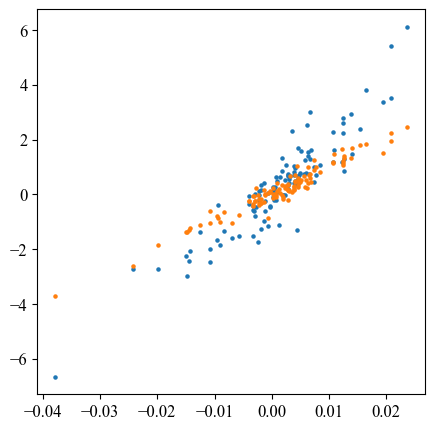

In [113]:
# port_ret[port_ret['date'].isin(speech_list)][['ex_port_ret', 'port_beta']].describe()
f, ax = plt.subplots(figsize = (5, 5))
ax.scatter(port_ret[port_ret['date'].isin(speech_list) & (port_ret['port_num'] == 9)]['vwretd'], port_ret[port_ret['date'].isin(speech_list) & (port_ret['port_num'] == 9)]['ex_port_ret'], s = 5)
ax.scatter(port_ret[port_ret['date'].isin(speech_list) & (port_ret['port_num'] == 3)]['vwretd'], port_ret[port_ret['date'].isin(speech_list) & (port_ret['port_num'] == 3)]['ex_port_ret'], s = 5)
# ax.scatter(port_ret[port_ret['date'].isin(['2022-08-26']) & (port_ret['port_num'] == 5)]['vwretd'], port_ret[port_ret['date'].isin(['2022-08-26']) & (port_ret['port_num'] == 5)]['ex_port_ret'], s = 5)

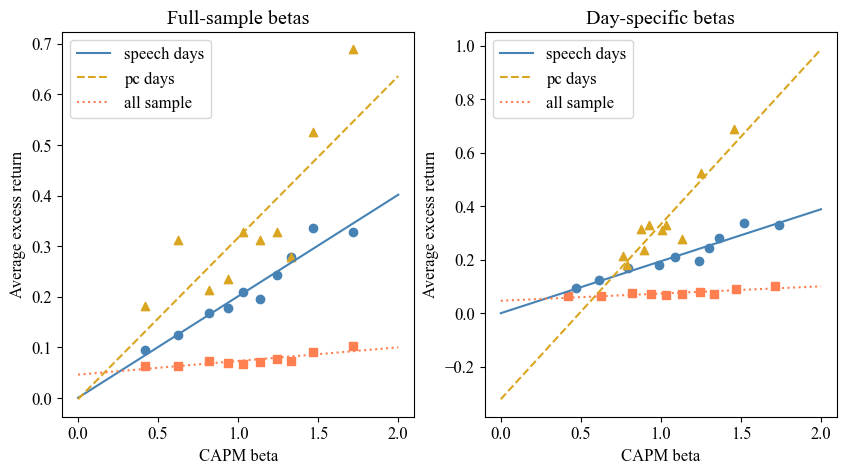

In [28]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
f, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, suffix in enumerate(['_all', '_day']):
    speech_line = port_ret[(port_ret['date'].isin(speech_list))].groupby('port_num')[['port_beta'+suffix, 'ex_port_ret']].mean()
    pc_line = port_ret[port_ret['date'].isin(pc_list)].groupby('port_num')[['port_beta'+suffix, 'ex_port_ret']].mean()
    all_sample = port_ret.groupby('port_num')[['port_beta'+suffix, 'ex_port_ret']].mean()

    speech_line_fn = np.poly1d(np.polyfit(speech_line['port_beta'+suffix], speech_line['ex_port_ret'], 1))
    pc_line_fn = np.poly1d(np.polyfit(pc_line['port_beta'+suffix], pc_line['ex_port_ret'], 1))
    all_sample_fn = np.poly1d(np.polyfit(all_sample['port_beta'+suffix], all_sample['ex_port_ret'], 1))

    x_fn = np.arange(0, 2.1, 0.1)
    ax[i].scatter(speech_line['port_beta'+suffix], speech_line['ex_port_ret'], marker = 'o', color = 'steelblue')
    ax[i].plot(x_fn, speech_line_fn(x_fn), color = 'steelblue', linestyle = '-', label = 'speech days')
    ax[i].scatter(pc_line['port_beta'+suffix], pc_line['ex_port_ret'], marker = '^', color = 'goldenrod')
    ax[i].plot(x_fn, pc_line_fn(x_fn), color = 'goldenrod', linestyle = '--', label = 'pc days')
    ax[i].scatter(all_sample['port_beta'+suffix], all_sample['ex_port_ret'], marker = 's', color = 'coral')
    ax[i].plot(x_fn, all_sample_fn(x_fn), color = 'coral', linestyle = ':', label = 'all sample')
    ax[i].set(ylabel='Average excess return', xlabel='CAPM beta')
    if i == 0:
        ax[i].set_title('Full-sample betas')
    else:
        ax[i].set_title('Day-specific betas')
    ax[i].legend()

plt.savefig(folder + '_05_output/figures/Average excess portfolio returns(2011-2020).png')

In [7]:
from portfolio_return import portfolio_return

In [16]:
folder = 'D:/Dropbox/Projects/Asset Pricing and Speeches by the Fed/'
data = pd.read_pickle(folder + '_04_processed_date/beta.pickle')
risk_free = pd.read_csv(folder + '_03_raw_data/market yield on one-month treasury bill/DGS1MO.csv')
risk_free = risk_free.rename(columns={'DATE': 'date', 'DGS1MO': 'risk_free'})

"""
0: Other days
1: Speech days
2: PC days
"""
data['day_type'] = np.where(data['date'].isin(speech_list), 1, np.where(data['date'].isin(pc_list), 2, 0))

print('start analysis...')
ptr = portfolio_return(data, risk_free, '2011-01-01', '2024-01-01', 'value')
all_day = ptr.fama_macbeth_reg(day_specific=False)
day_spe = ptr.fama_macbeth_reg(day_specific=True)
result = pd.concat(objs=[all_day, day_spe], axis=1)
print(result)

start analysis...
Instance constructed
Fama Macbeth regression finished
Fama Macbeth regression finished
               All-sample betas                     Day-specific betas  \
                      Intercept    Slope Avg. $R^2$          Intercept   
Other days                0.029    0.037      0.507              0.032   
                        [0.082]  [0.094]        NaN            [0.051]   
Speech days               0.016    0.148      0.491              0.027   
                        [0.417]   [0.11]        NaN            [0.353]   
PC days                  -0.312     0.62      0.455             -0.268   
                         [0.98]  [0.002]        NaN            [0.972]   
$\Delta$Speech            0.016    0.148        NaN              0.027   
                        [0.863]  [0.254]        NaN            [0.758]   
$\Delta$PC               -0.312     0.62        NaN             -0.268   
                        [0.023]  [0.001]        NaN            [0.035]   

      

In [19]:
ptr.beta_all_sample['year'] = ptr.beta_all_sample['date'].apply(lambda x: int(x.split('-')[0]))
pc = ptr.beta_all_sample[ptr.beta_all_sample['date'].isin(pc_list)]
speech = ptr.beta_all_sample[ptr.beta_all_sample['date'].isin(speech_list)]